In [15]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import gym
from random import random
from gym import Env, spaces
import skgeom as sg
from skgeom import Point2,Line2,Segment2
import sklearn
import sympy.geometry

class MeshEnvironment(Env):
    
    def __init__(self,vertices):
        
        super(MeshEnvironment,self).__init__()
        
        #define action space: add 0,1 or 2 vertices
        self.action_space = spaces.Discrete(3,)
        
        #define observation space: number of vertices forming the boundary - initialized in initialize_env(vertices)
        #self.observation_space = spaces.Box(8,)
        
        #points defining the boundary
        if vertices is None:
            self.vertices = self.convex_hull_points(16)
        else:
            self.vertices = vertices
        
        self.polygon = sg.Polygon(self.vertices)
        
        #points defining the partial observation
        self.p0 = None
        self.pl1 = None
        self.pl2 = None
        self.pr1 = None
        self.pr2 = None
        self.pt1 = None
        self.pt2 = None
        self.pt3 = None
    
    def convex_hull_points(self,n):
        
        points = []
        for i in range(n):
            points.append(Point2(random(),random()))
        return sg.convex_hull.graham_andrew(points)
        
    def initialize_env():
        
        #find smallest angle to build quadrilateral
        p0_index = find_smallest_angle()
        #get partial observation
        self.observation_space = get_partial_observation(p0_index)
        
    def step(self):
        done = False
        
        #initialize observation_space
        initialize_env()
        
        action = choose_action
        if action==0:
            self.reward = action_0()
        if action==1:
            self.reward = action_1()
        if action==2:
            self.reward = action_2()
        
        self.ep_return = self.ep_return + self.reward
        pass
    
    def get_angle(self,point1,point2,point3):
        angle = None
        slope1, slope2 = 0, 0
        try:
            slope1 = float((point1.y()-point2.y())/(point1.x()-point2.x()))
            slope2 = float((point3.y()-point2.y())/(point3.x()-point2.x()))
            if(slope1*slope2==-1):
                angle = math.pi/2
            else:
                angle = np.arctan(np.abs((slope1-slope2)/(1+slope1*slope2)))
        except RuntimeError:

            #if angle is with horizontal line
            if slope1 == 0 and slope2 != 0:
                angle = np.arctan(np.abs(slope2))
            elif slope2 == 0 and slope1 != 0:
                angle = np.arctan(np.abs(slope1))

            #if angle is with a vertical (undefined) line
            else:
                if(point1.x() == point2.x()):
                    return (90 - get_angle(sg.Point2(point2.x() + 5,point2.y()),point2,point3))
                elif(point2.x() == point3.x()):
                    return (90 - get_angle(point1,point2,sg.Point2(point2.x() + 5,point2.y())))
        return angle*180/math.pi
    
    def find_smallest_angle(polygon):
        if self.polygon is None:
            return None
        else:
            angles = []
            points = list(polygon.vertices)
            for i in range(len(points)-2):
                angles.append(angle(points[i],points[i+1],points[i+2]))
            
            return (angles.index(np.min(angles)) + 1)
        
    def get_partial_observation(p0_index):
        
        partial_observation = []
        
        pl1_index = get_point_index(p0_index,-1)
        pl2_index = get_point_index(p0_index,-2)
        pr1_index = get_point_index(p0_index,1)
        pr2_index = get_point_index(p0_index,2)
        
        center = self.vertices[p0_index]
        radius = 3
        sector_start = self.vertices[pr1_index]
        sector_end = self.vertices[pl1_index]
        
        #Check if there are any points inside the sector of circle centered at P0
        #where the sector is spanning pl1 and pr1
        
        points_inside = []
        
        
        #Choose points closest to P0 in each fan-shaped areas created
    
    def get_fan_shaped_angle(self,pl1,p0,pr1,radius,index):
        origin_on_arc = sg.Point2(p0.x(),p0.y()+radius)
        angle_sector = get_angle(pl1,p0,pr1)
        angle_offset = get_angle(pl1,p0,origin_on_arc)
        if is_clockwise(pl1,origin_on_arc):
            angle_offset = -angle_offset
        angle_third = angle_sector/3
        angle_of_interest = index*angle_third + angle_third/2 + angle_offset
        return angle_offset,angle_third,angle_of_interest
    
    def get_fan_shaped_start_end(self,pl1,p0,pr1,radius):
        angle_offset, andlge_third, angle_of_interest_start = get_fan_shaped_angle(pl1,p0,pr1,radius,0)
        angle_offset, andlge_third, angle_of_interest_end = get_fan_shaped_angle(pl1,p0,pr1,radius,2)
        start =  sg.Point2(radius*np.sin(angle_of_interest_start*math.pi/180) + p0.x(),radius*np.cos(angle_of_interest_start*math.pi/180) + p0.y())
        end =  sg.Point2(radius*np.sin(angle_of_interest_end*math.pi/180) + p0.x(),radius*np.cos(angle_of_interest_end*math.pi/180) + p0.y())
        return start,end

    def get_arc_midpoint(pl1,p0,pr1,index,radius):
        angle_offset, angle_third, angle_of_interest = get_fan_shaped_angle(pl1,p0,pr1,radius,index)
        midpoint = sg.Point2(radius*np.sin(angle_of_interest*math.pi/180) + p0.x(),radius*np.cos(angle_of_interest*math.pi/180) + p0.y())
        return midpoint
    
    def is_in_sector(sector_start,sector_end,radius,point):
        # To find if the point is counterclockwise to pr1 and clockwise to pl1
        if not is_clockwise(sector_start,point) and is_clockwise(sector_end,point):
            #if the point is inside the circle
            if((point.x()-center.x())^2 + (point.y()-center.y())^2 <= radius^2):
                return True
        return False

    def is_clockwise(v1,v2):
        return -v1.x()*v2.y() + v1.y()*v2.x() > 0
    
    def get_point_index(index,increment):
        if(index + increment < 0):
            return index + increment + len(self.vertices)
        elif(index + increment > len(self.vertices)):
            return index + increment - len(self.vertices)
        else:
            return idex + increment
        
    def action_0():
        pass
    
    def action_1():
        pass
    
    def action_2():
        pass
    
    def reset():
        self.vertices = []
        self.ep_return = 0

Polygon_2(
  PointC2(0.00811941, 0.114028)
  PointC2(0.844617, 0.0950842)
  PointC2(0.866862, 0.147584)
  PointC2(0.953524, 0.55825)
  PointC2(0.820967, 0.695514)
  PointC2(0.094915, 0.99296)
)



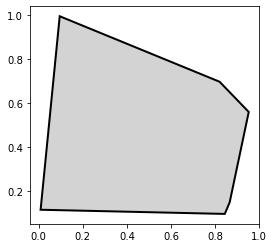

In [13]:
import skgeom
from skgeom.draw import draw
env = MeshEnvironment(None)
print(env.polygon)
draw(env.polygon)